## Fitness Tracker Analysis - Part 2

Continued from Part 1 here:

/notebooks/nk-fitness-tracker-exploratory-1.ipynb

### 4 - Detecting Outliers in Sensor Data

The next step is to check whether there are extreme values or outliers in the data that should be removed before modeling.

Load the necessary libraries:

In [14]:
import math
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import display

Set the plotting style:

In [15]:
mpl.style.use("seaborn-v0_8-deep")
mpl.rcParams["figure.figsize"] = (20, 5)
mpl.rcParams["figure.dpi"] = 100

Load the preprocessed dataset into pandas DataFrame:

In [3]:
df = pd.read_pickle("../data/interim/01_data_processed.pkl")

array([<Axes: title={'center': 'gyr_x'}, xlabel='[label]'>,
       <Axes: title={'center': 'gyr_y'}, xlabel='[label]'>,
       <Axes: title={'center': 'gyr_z'}, xlabel='[label]'>], dtype=object)

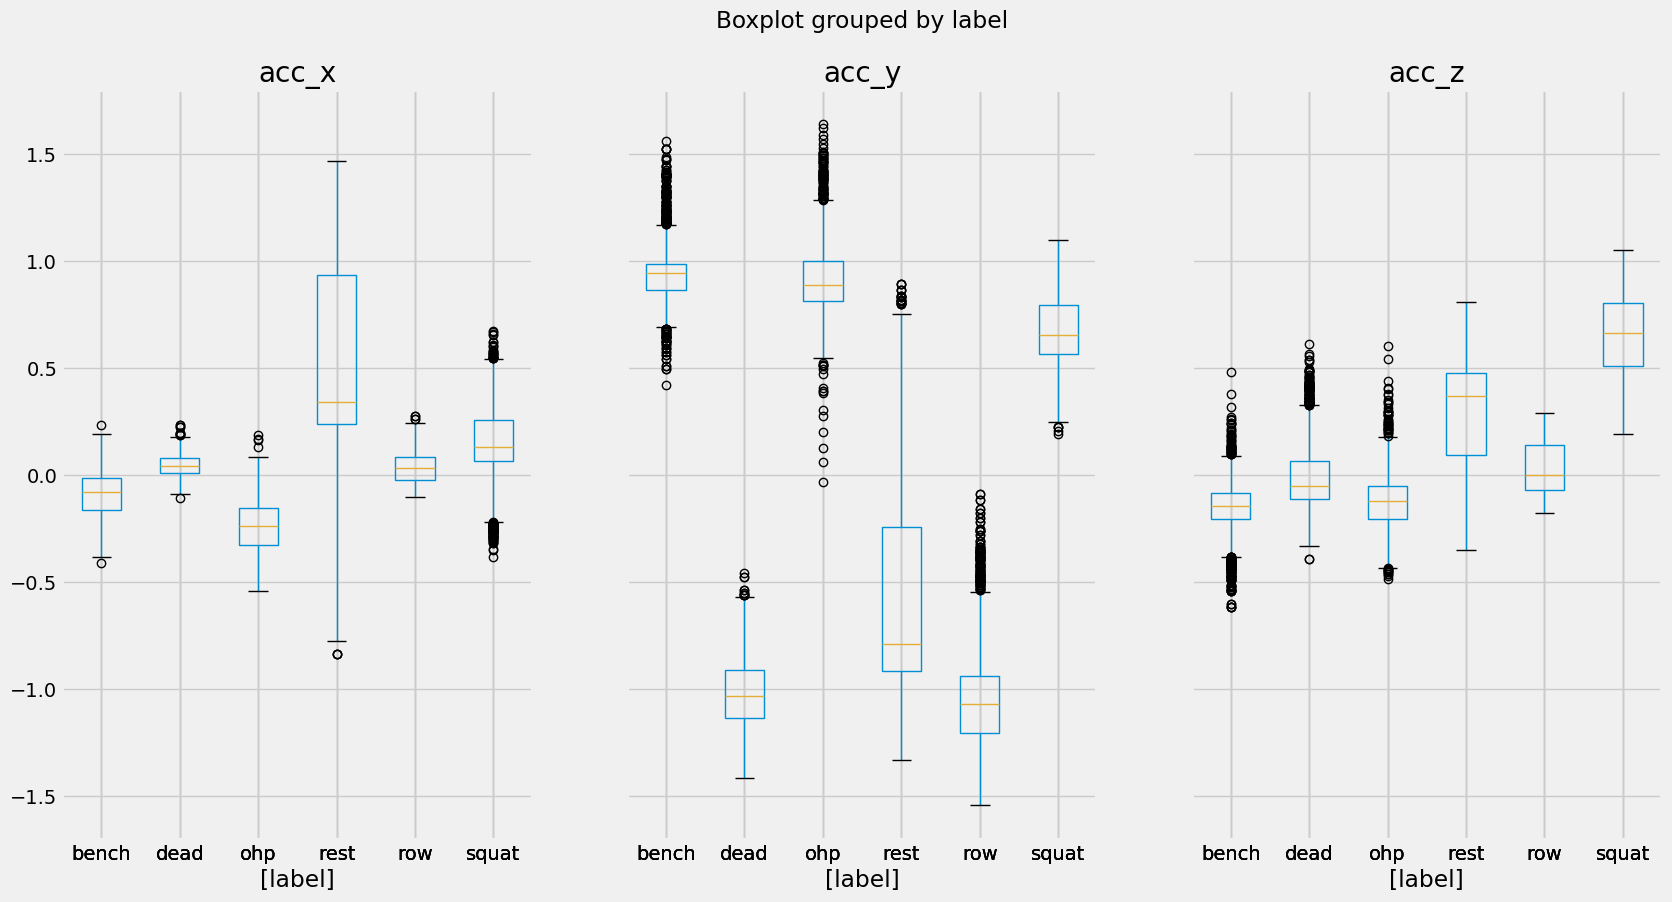

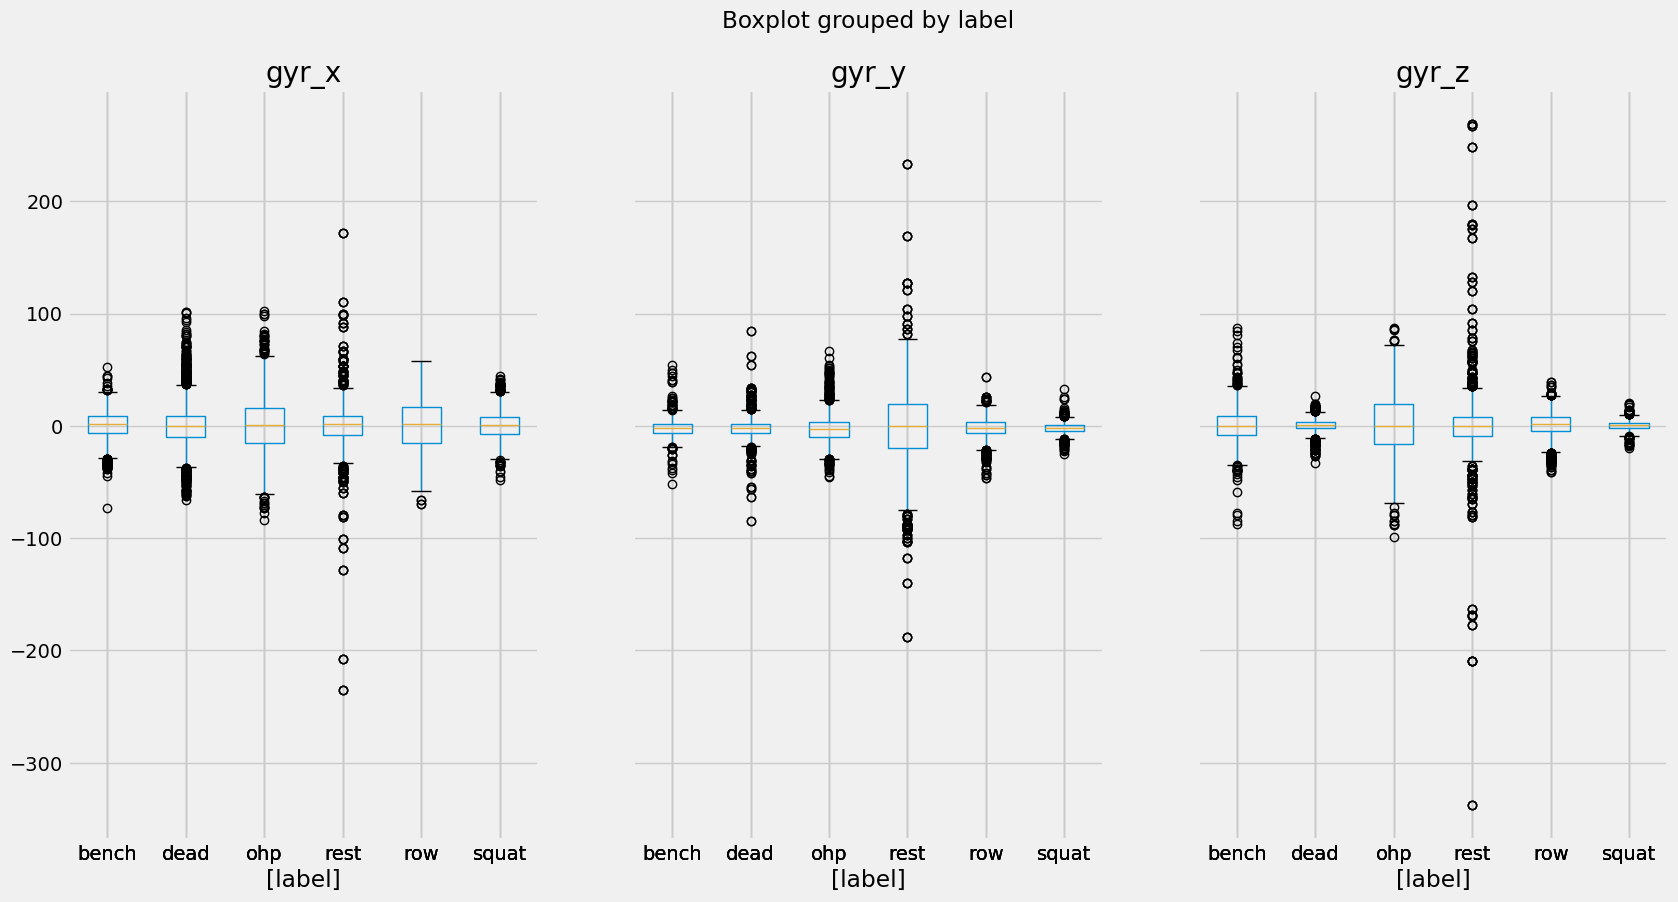

In [16]:
# Use box plots to see the extent of outliers in each type of exercise
outlier_columns = list(df.columns[:6])

plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams["figure.dpi"] = 100

df[outlier_columns[:3] + ["label"]].boxplot(by="label", figsize=(20, 10), layout=(1, 3))
df[outlier_columns[3:] + ["label"]].boxplot(by="label", figsize=(20, 10), layout=(1, 3))

Plotting outliers in each set shows a lot of extreme values, but we can't just remove them all using a brute force strategy. We need to visualize them in other ways to see if there's a pattern among these outliers. This way, we can make an informed choice using the outlier detection functions below.

#### 4.1 - Define Binary Outlier Scores

Use Mark Hoogendoorn's function to plot binary outlier scores. Source code can be found here:

https://github.com/mhoogen/ML4QS/blob/master/Python3Code/util/VisualizeDataset.

Define `plot_binary_outliers()` as follows:

In [17]:
def plot_binary_outliers(dataset, col, outlier_col, reset_index):
    dataset = dataset.dropna(axis=0, subset=[col, outlier_col])
    dataset[outlier_col] = dataset[outlier_col].astype("bool")

    if reset_index:
        dataset = dataset.reset_index()

    fig, ax = plt.subplots()

    plt.xlabel("samples")
    plt.ylabel("value")

    # Plot non outliers in default color
    ax.plot(
        dataset.index[~dataset[outlier_col]],
        dataset[col][~dataset[outlier_col]],
        "+",
    )
    # Plot data points that are outliers in red
    ax.plot(
        dataset.index[dataset[outlier_col]],
        dataset[col][dataset[outlier_col]],
        "r+",
    )

    plt.legend(
        ["outlier " + col, "no outlier " + col],
        loc="upper center",
        ncol=2,
        fancybox=True,
        shadow=True,
    )
    plt.show()

#### 4.2 - Inquartile Ranges Method for Outlier Detection

When using a boxplot, the box extends from Q1 to Q3 quartile values of the data, when a line across the median (Q2). The whiskers extend from the edges of the box to show the full range of data, including outliers. By default, they extend no more than 1.5 * IQR, where IQR = Q3 - Q1, from the edges of the box. Any data points beyond the whiskers are considered outliers.

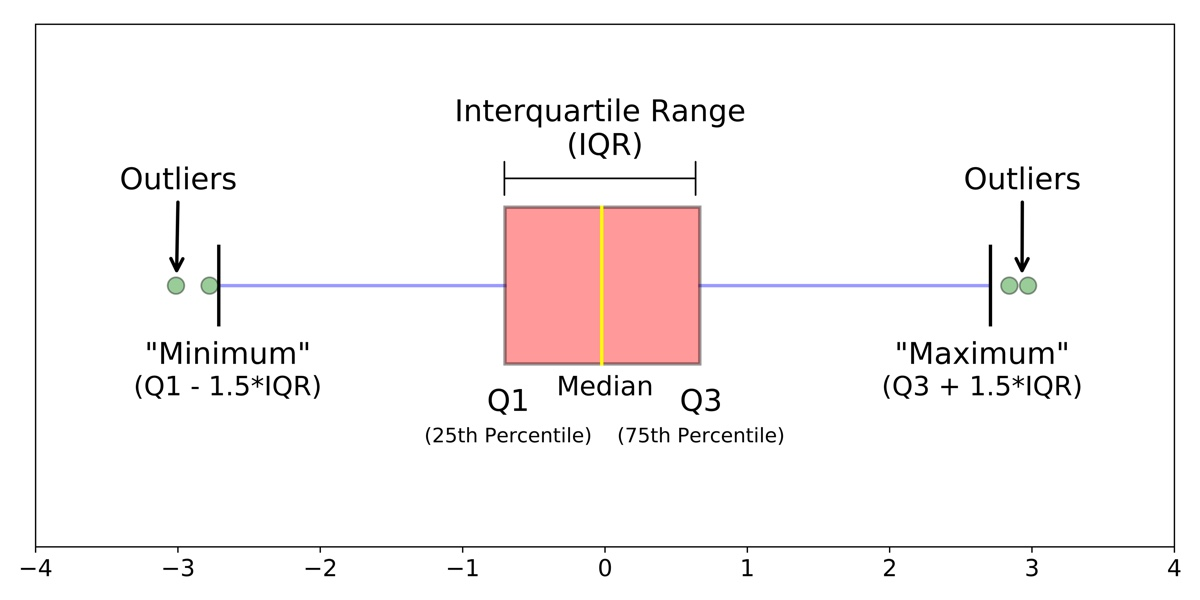

Image from: https://www.linkedin.com/in/michaelgalarnyk/

Define `mark_outliers_iqr()` as follows:

In [18]:
def mark_outliers_iqr(dataset, col):
    dataset = dataset.copy()

    Q1 = dataset[col].quantile(0.25)
    Q3 = dataset[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    dataset[col + "_outlier"] = (dataset[col] < lower_bound) | (
        dataset[col] > upper_bound
    )

    return dataset

#### 4.3 - Plotting Outliers Using the Boxplot and IQR Method

Test this method and mark outliers as red, normal data points as blue.

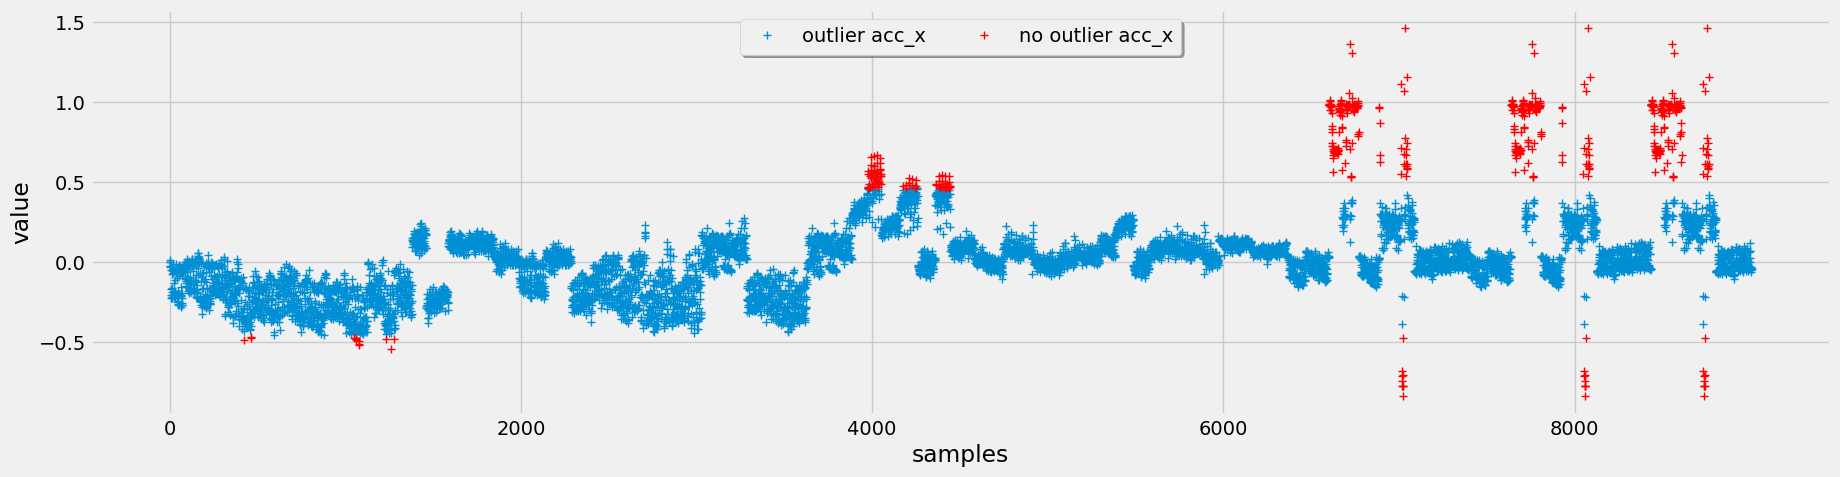

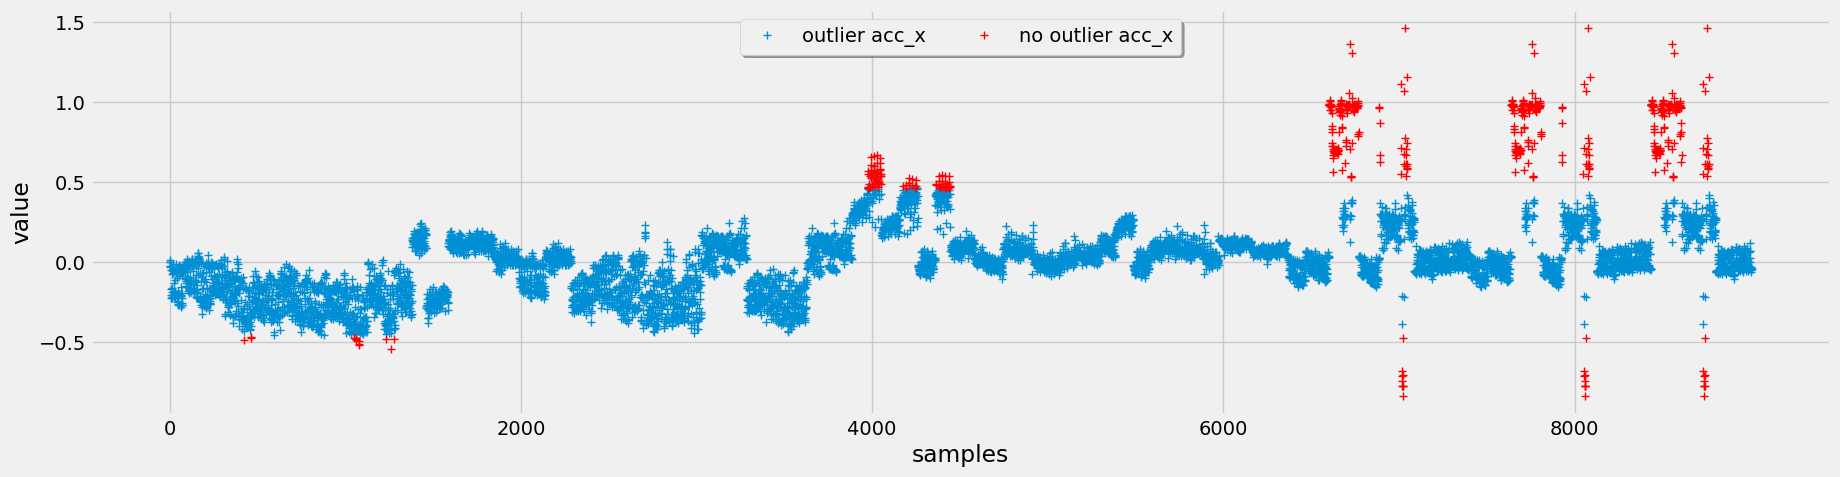

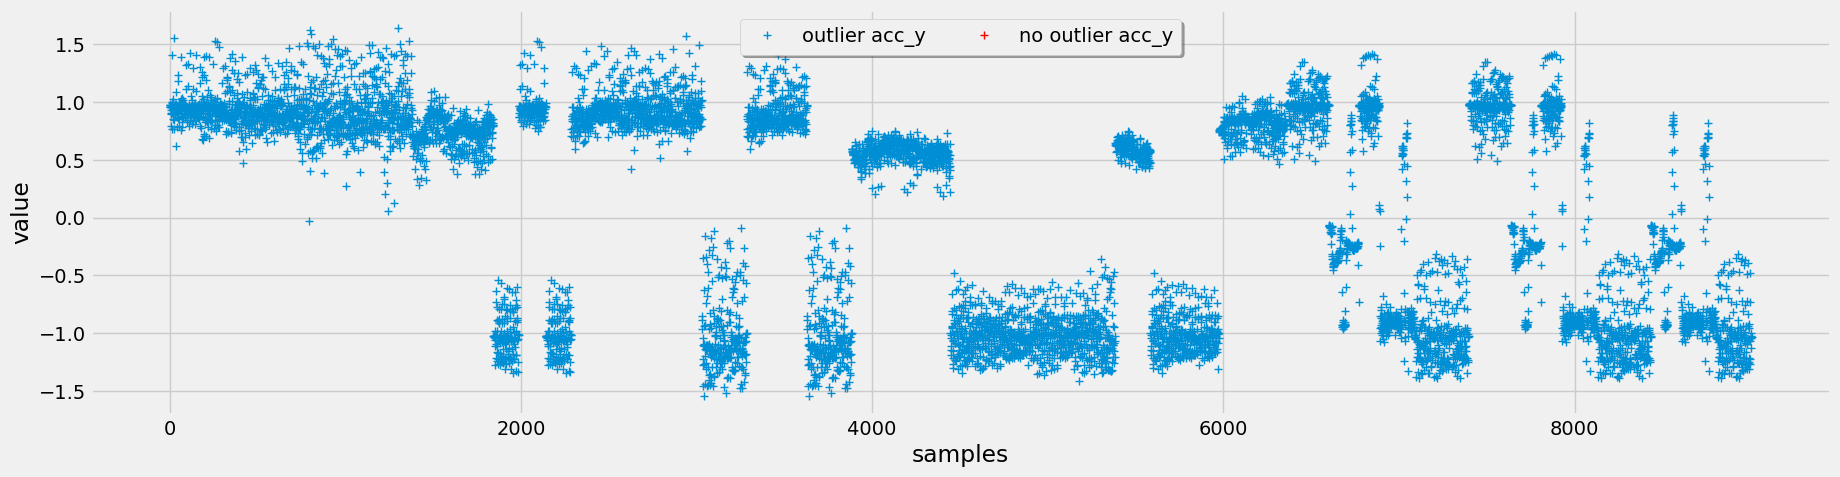

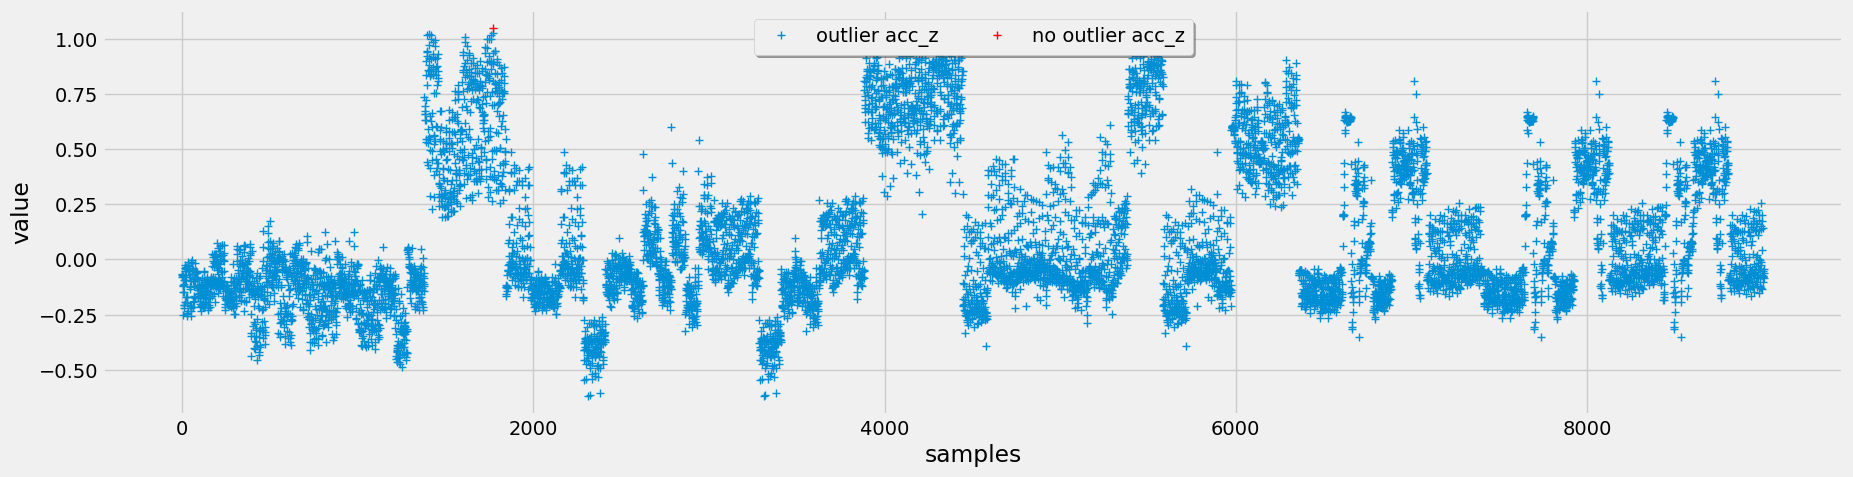

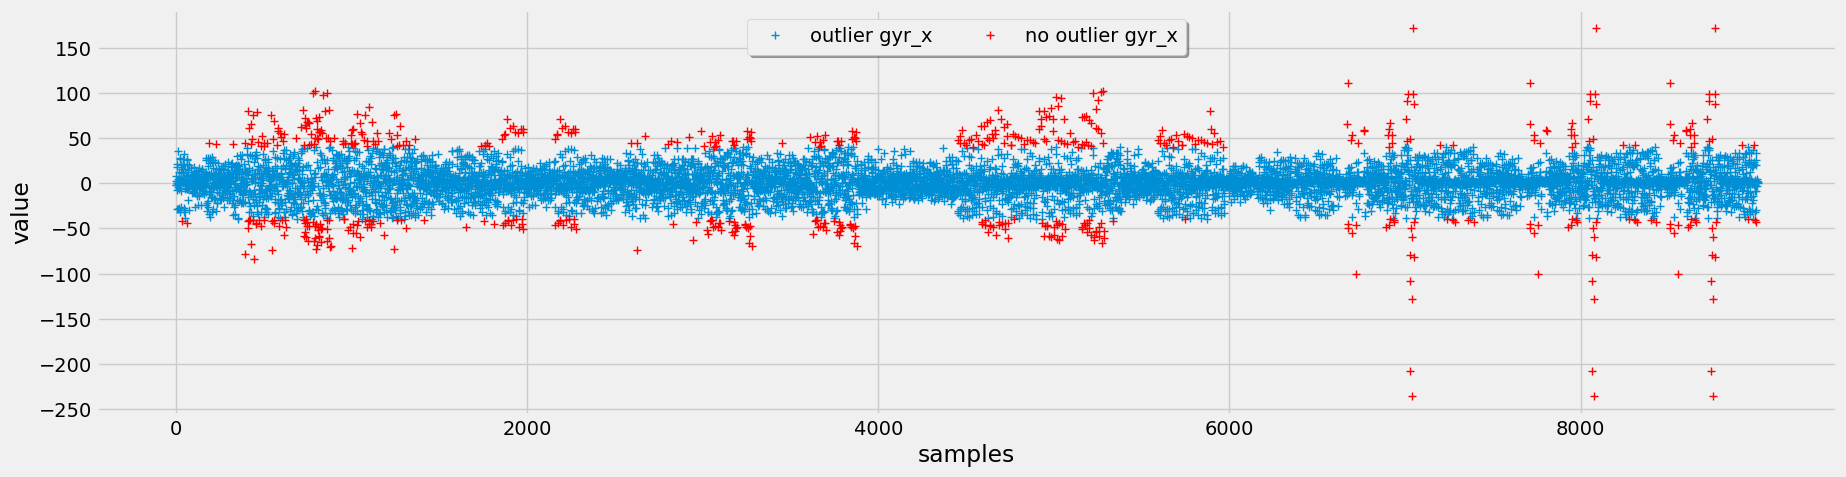

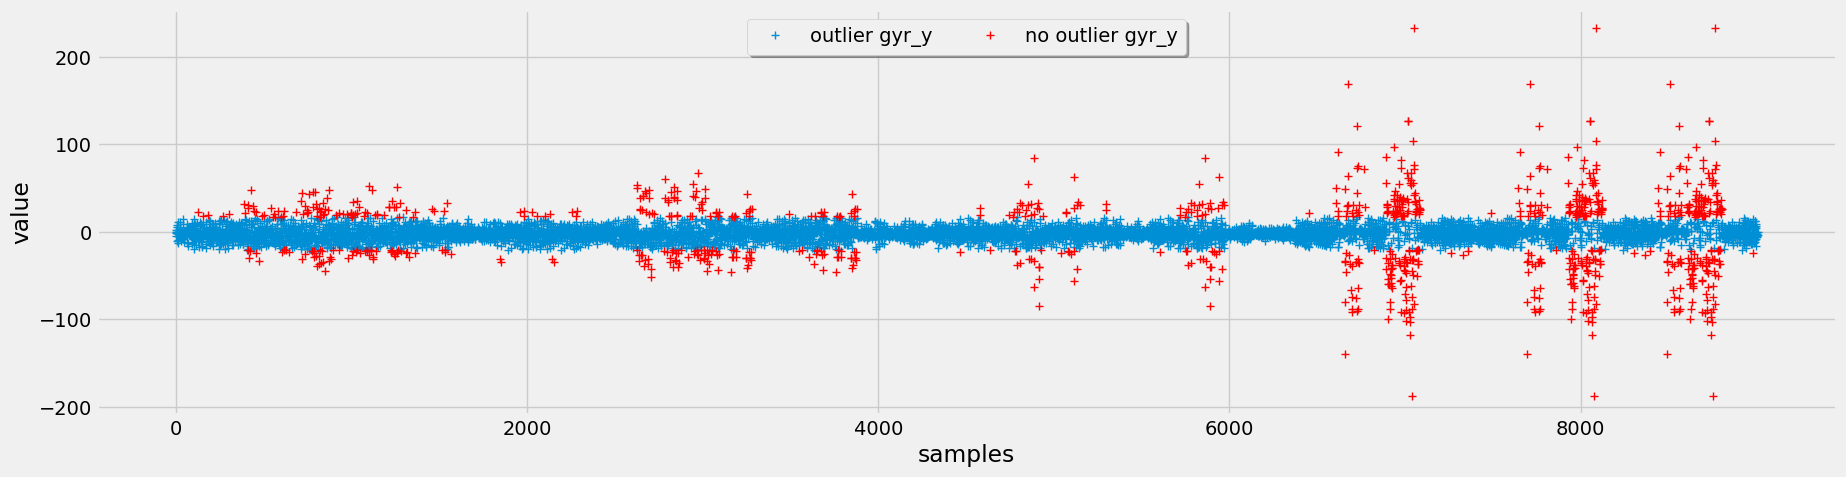

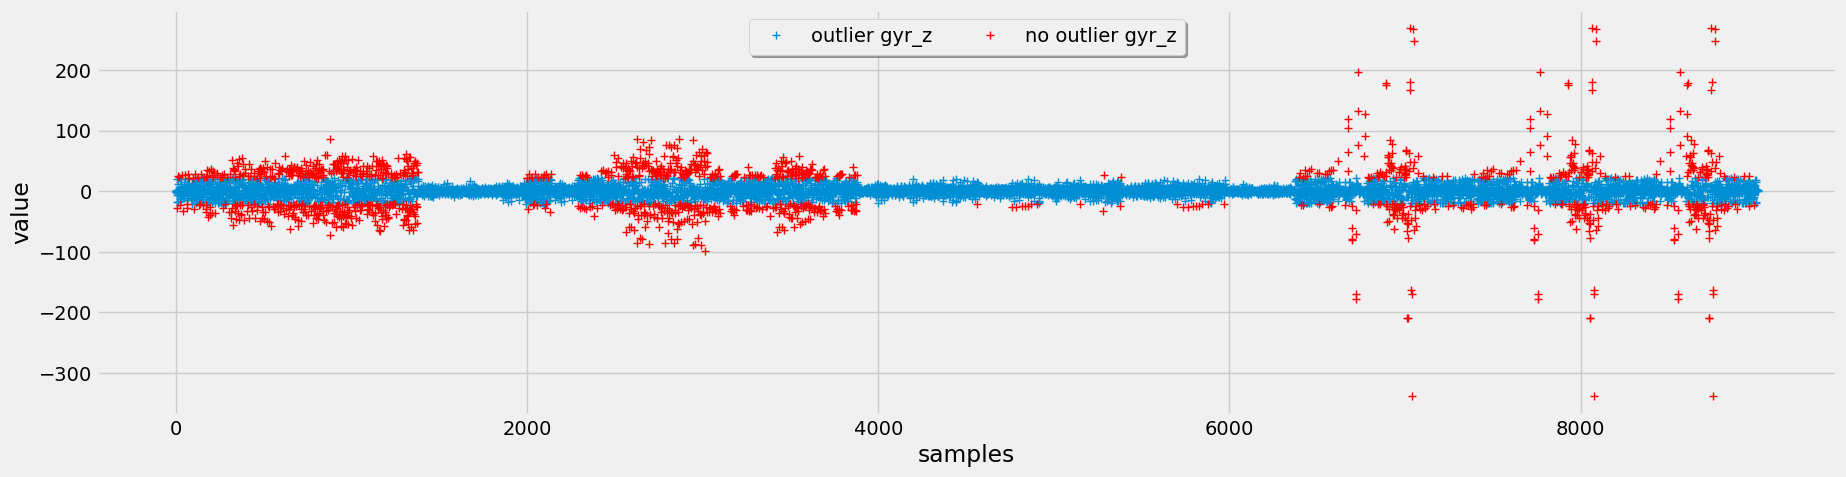

In [19]:
# Plot a single column
col = "acc_x"
dataset = mark_outliers_iqr(df, col)
plot_binary_outliers(
    dataset=dataset, col=col, outlier_col=col + "_outlier", reset_index=True
)

# Loop over all columns
for col in outlier_columns:
    dataset = mark_outliers_iqr(df, col)
    plot_binary_outliers(
        dataset=dataset, col=col, outlier_col=col + "_outlier", reset_index=True
    )

As seen above, using the IQR method still shows too many outliers and many of these flagged data points may be legit. Another method should be attempted before making a final decision on handling outliers.

#### 4.4 - Chauvenet's Criterion for Outlier Detection

Chauvenet's criterion is a method for detecting outliers based on the idea that for normally distributed data, the probability of an outlier is relatively low. This won't work if the data isn't normally distributed, however. 

This method rejects an outlier from a dataset of size `N` when the probability of such observation is less than `1 / (C * N)` where `C` is usually 2.

Source: Hoogendoorn, M., & Funk, B. (2018). Machine learning for the quantified self. On the art of learning from sensory data.

Source code of Chauvenet's function can be found here:

https://github.com/mhoogen/ML4QS/blob/master/Python3Code/Chapter3/OutlierDetection.py

Define `mark_outliers_chauvenet()` as follows:

In [20]:
def mark_outliers_chauvenet(dataset, col, C=2):
    dataset = dataset.copy()

    # Compute the mean and standard deviation.
    mean = dataset[col].mean()
    std = dataset[col].std()
    N = len(dataset.index)
    criterion = 1.0 / (C * N)

    # Consider the deviation for the data points.
    deviation = abs(dataset[col] - mean) / std

    # Express the upper and lower bounds.
    low = -deviation / math.sqrt(C)
    high = deviation / math.sqrt(C)
    prob = []
    mask = []

    # Pass all rows in the dataset.
    for i in range(0, len(dataset.index)):

        # Determine the probability of observing the point
        prob.append(
            1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
        )

        # And mark as an outlier when the probability is below our criterion.
        mask.append(prob[i] < criterion)

    dataset[col + "_outlier"] = mask
    return dataset

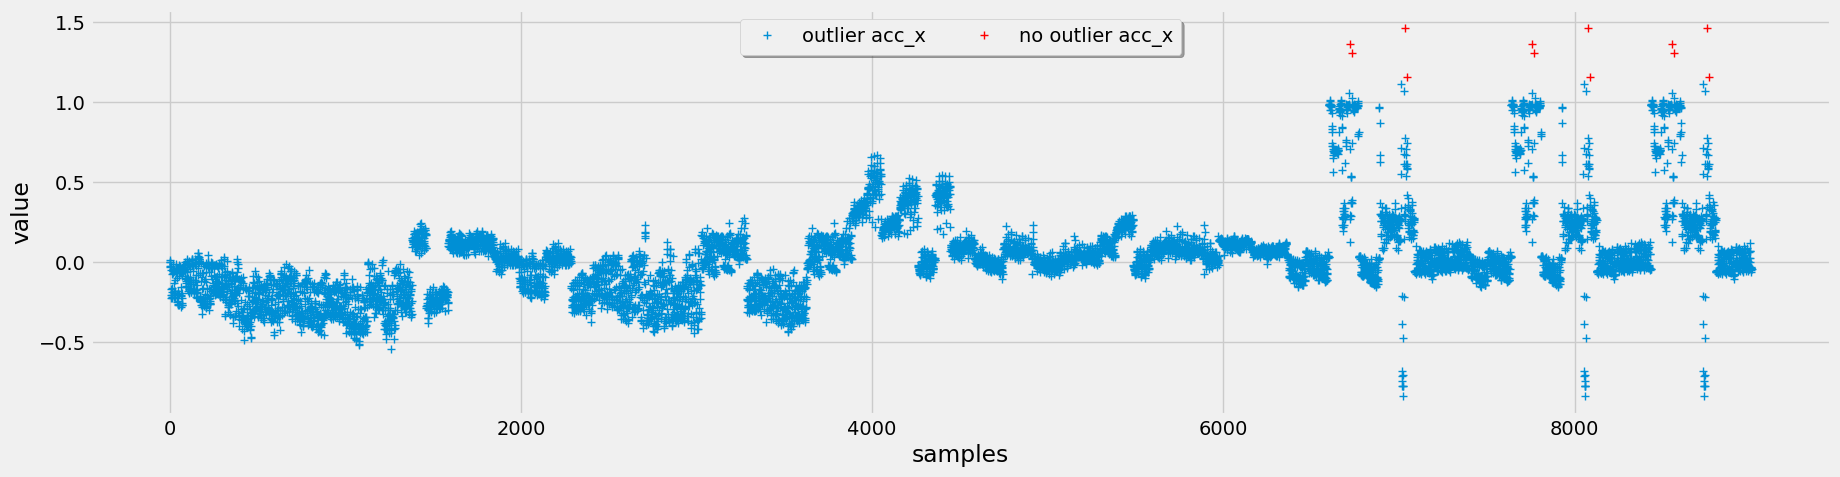

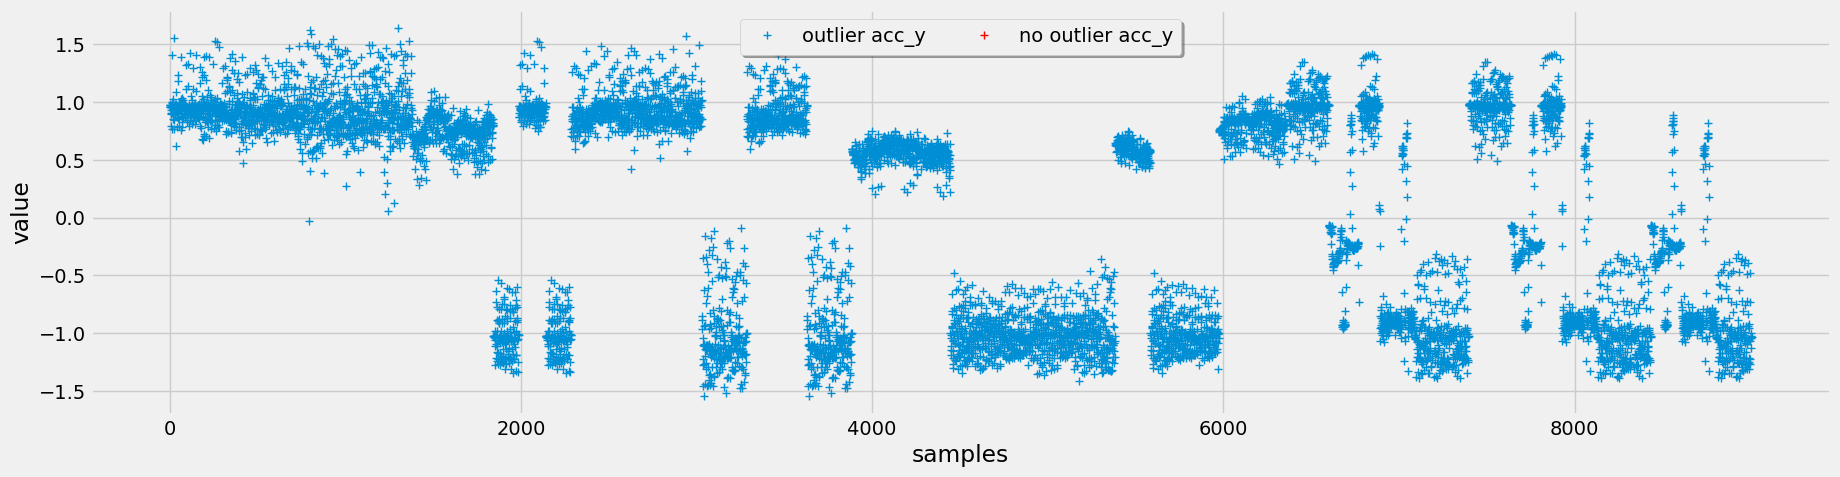

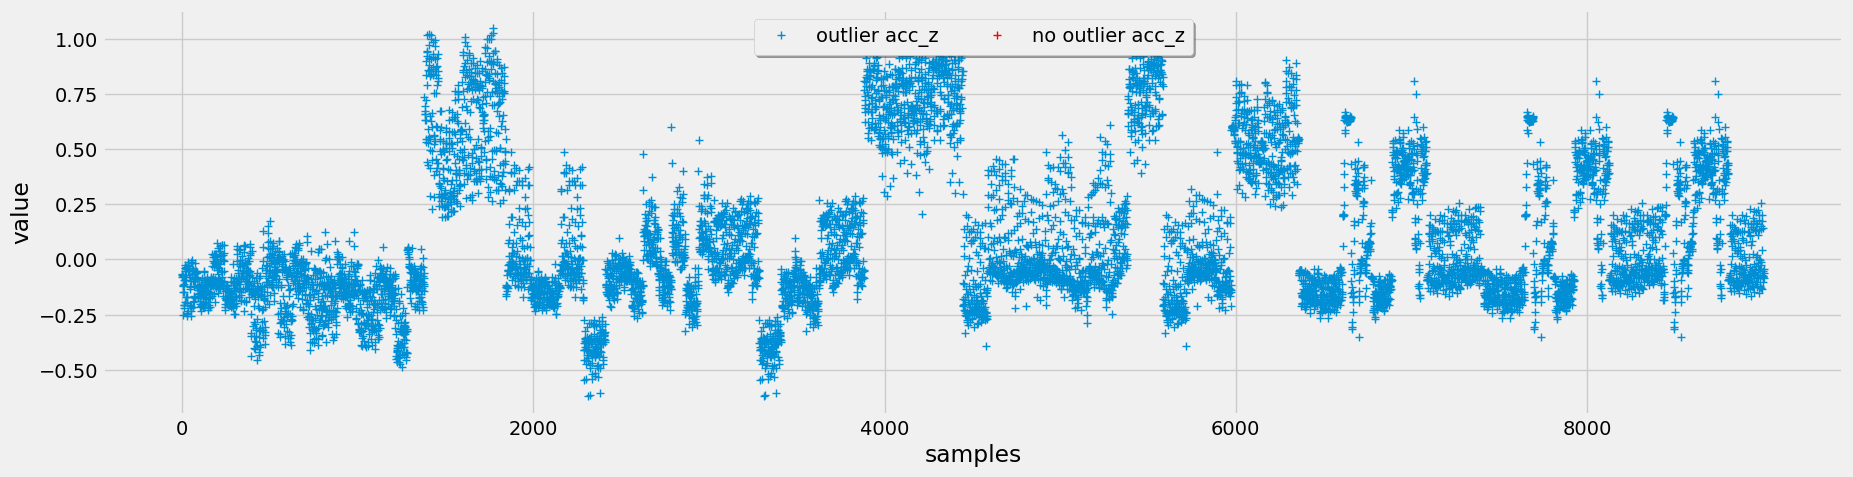

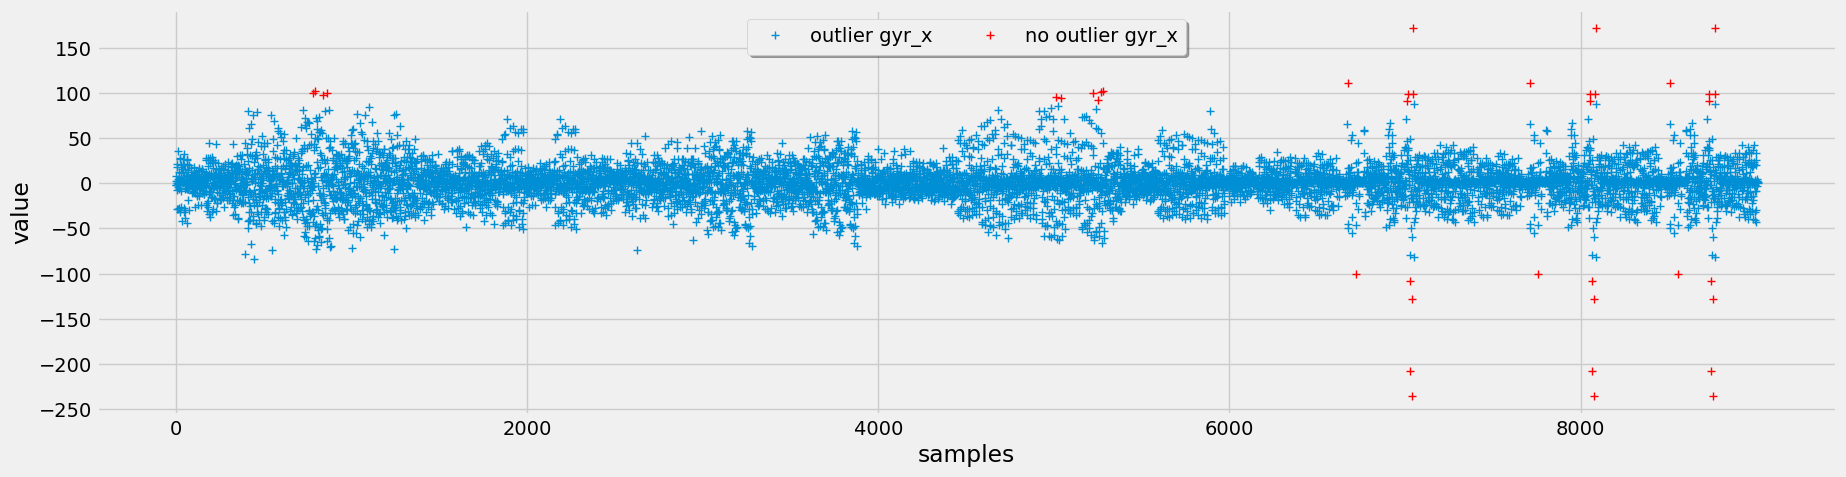

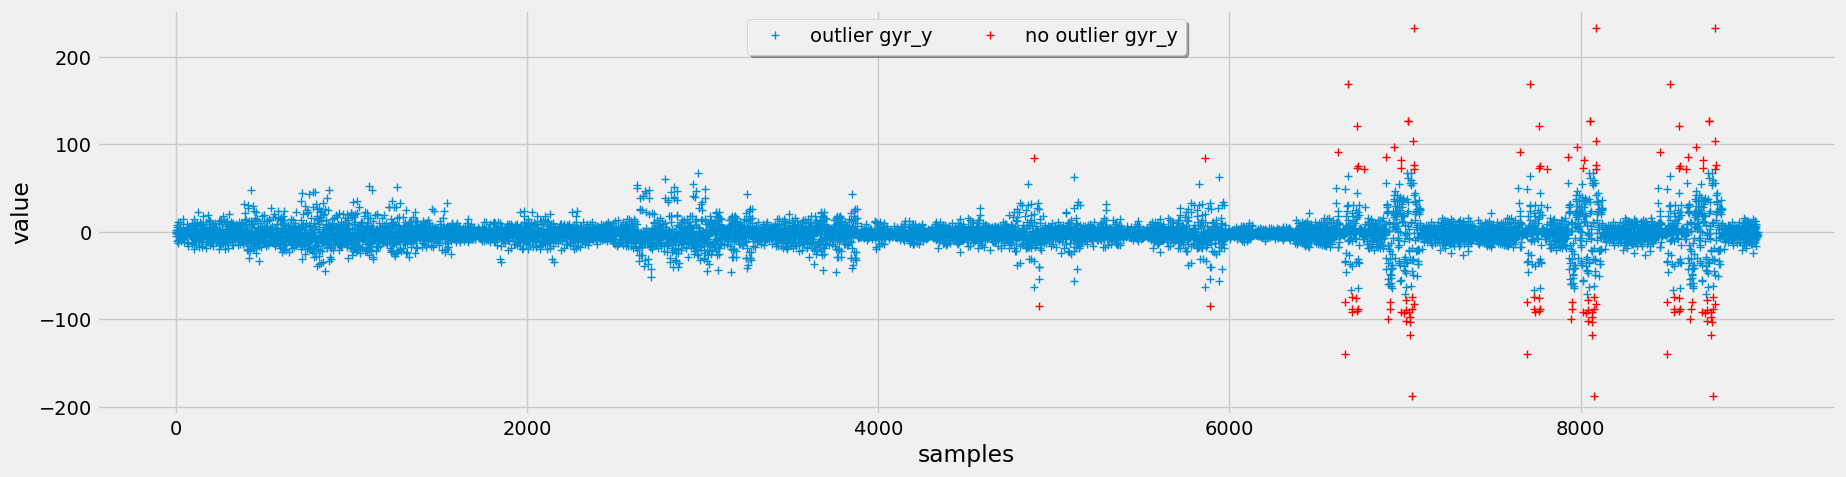

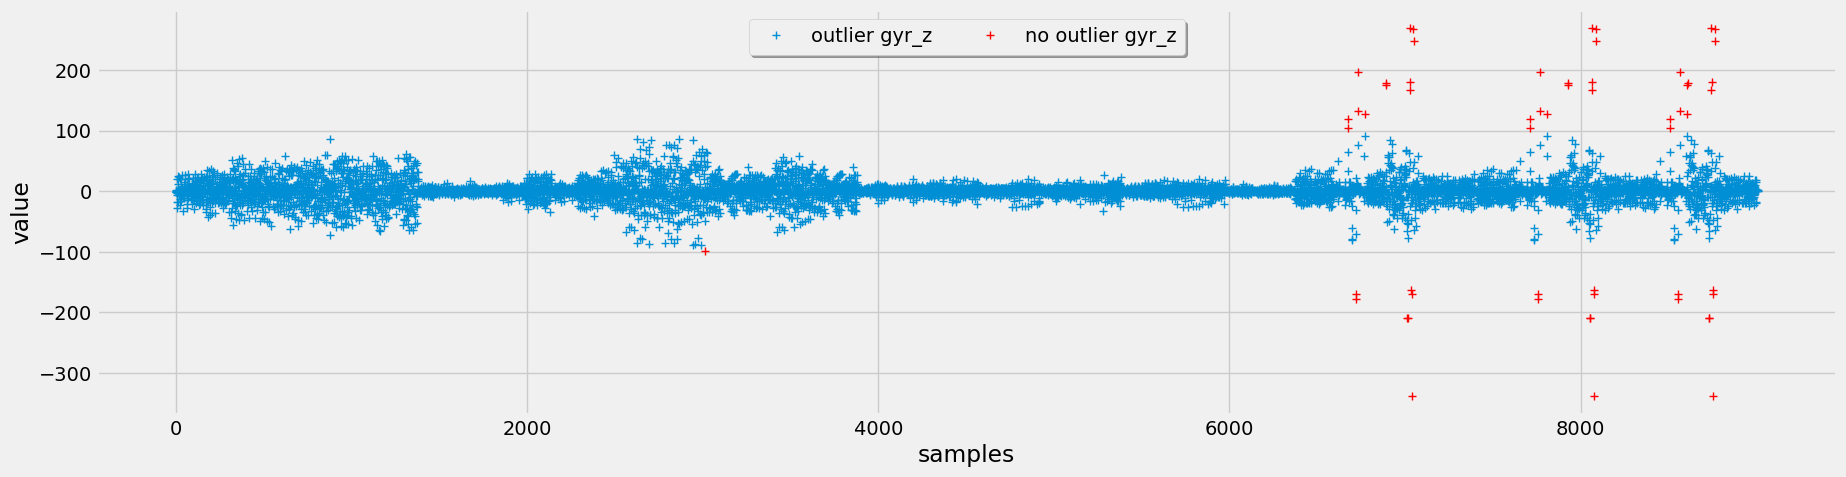

In [21]:
# Test the Chauvenet criterion on all columns
for col in outlier_columns:
    dataset = mark_outliers_chauvenet(df, col)
    plot_binary_outliers(
        dataset=dataset, col=col, outlier_col=col + "_outlier", reset_index=True
    )


Using Chauvenet's method results in less outliers, which likely means they are true outliers.

#### 4.5 - Local Outlier Factor (LOF)

LOF is an unsupervised outlier detection method that assigns an anomaly score to each observation. The anomaly score is based on the distance of a sample with respect to its neighbors. 

In [22]:
from sklearn.neighbors import LocalOutlierFactor

def mark_outliers_lof(dataset, columns, n=20):
    dataset = dataset.copy()

    lof = LocalOutlierFactor(n_neighbors=n)
    data = dataset[columns]
    outliers = lof.fit_predict(data)
    X_scores = lof.negative_outlier_factor_

    dataset["outlier_lof"] = outliers == -1

    return dataset, outliers, X_scores


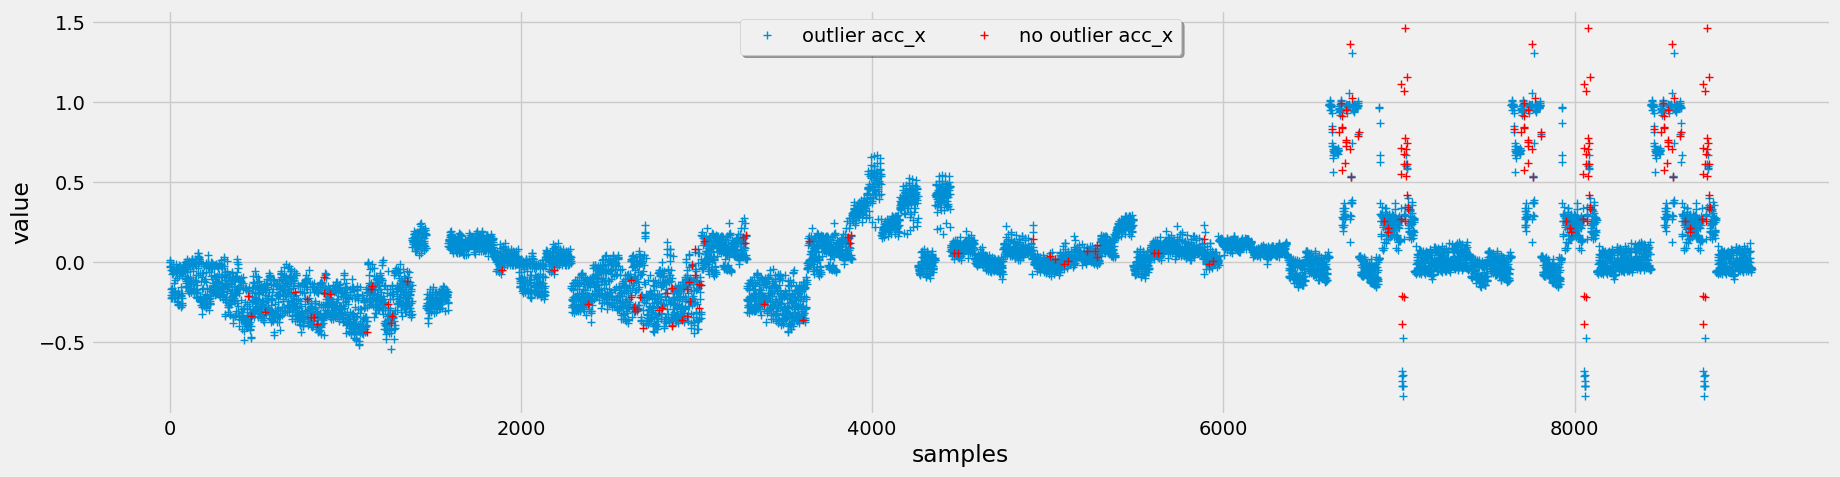

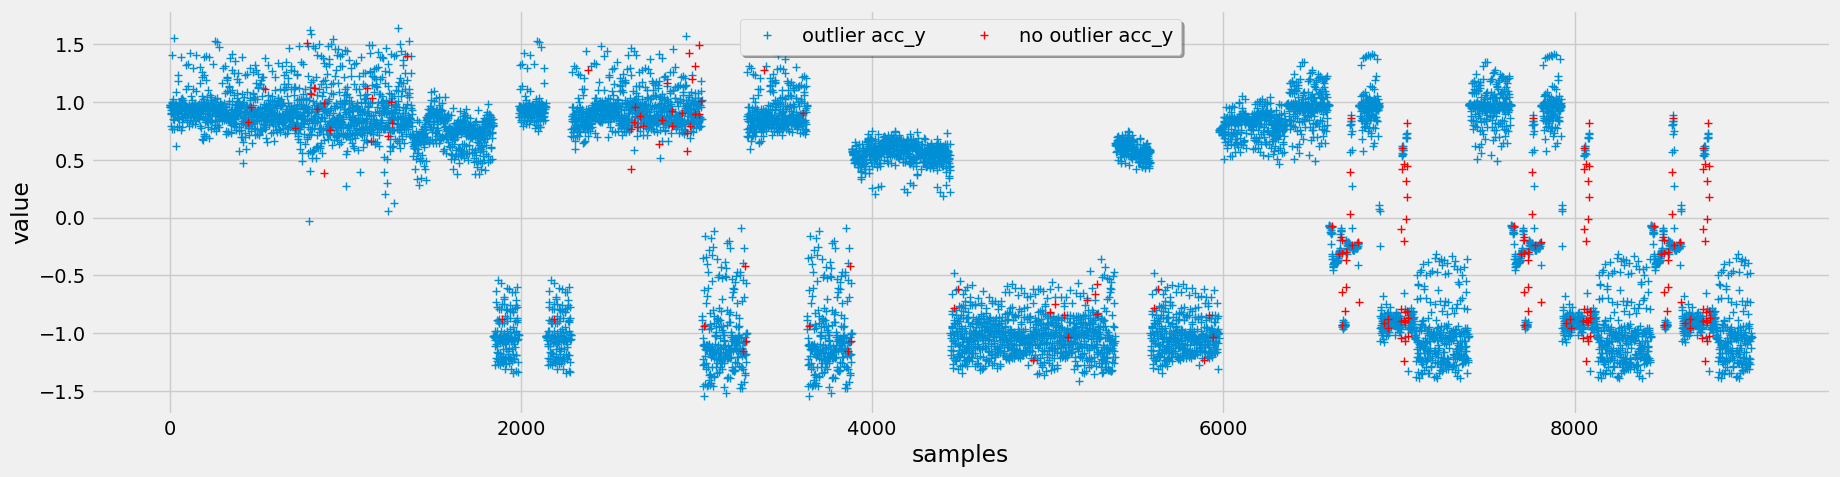

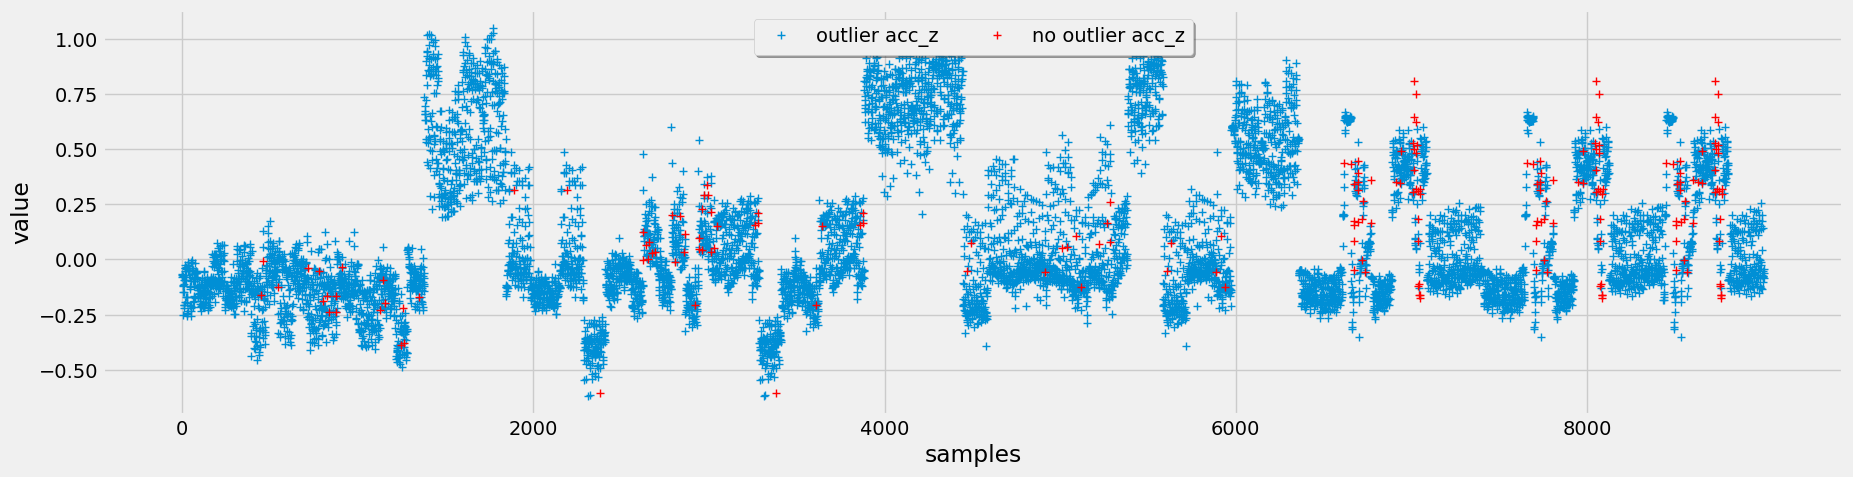

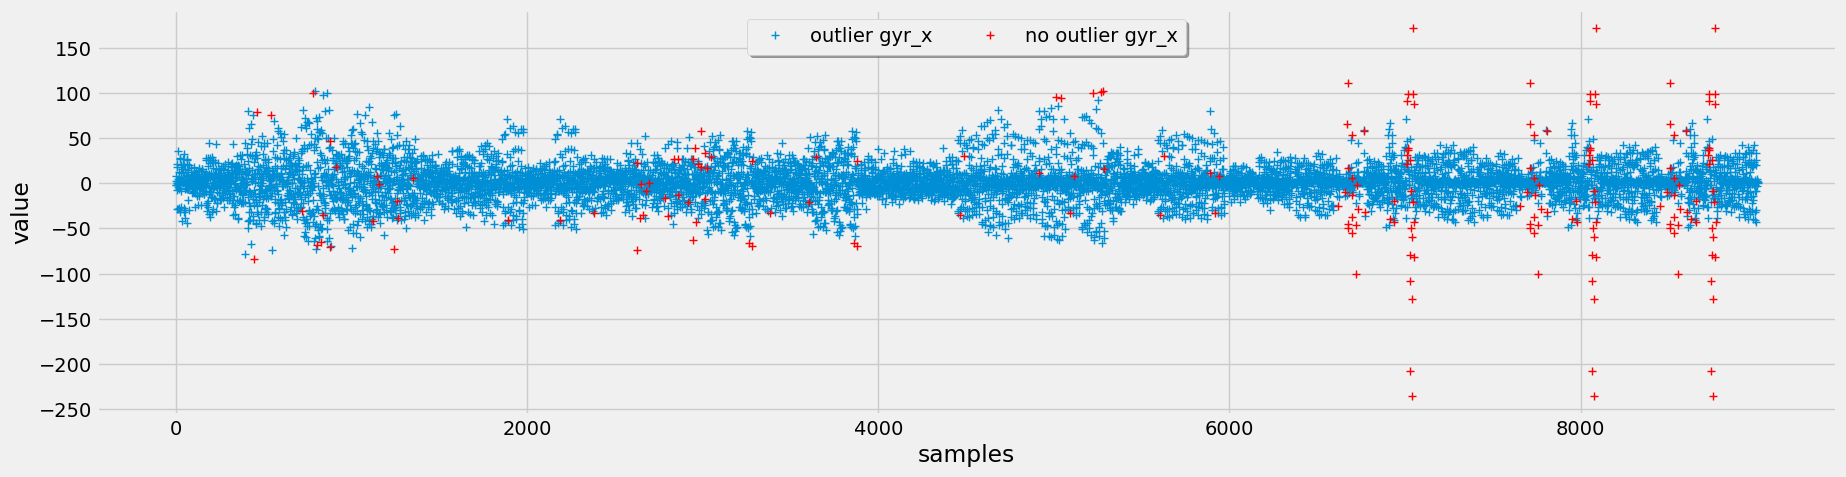

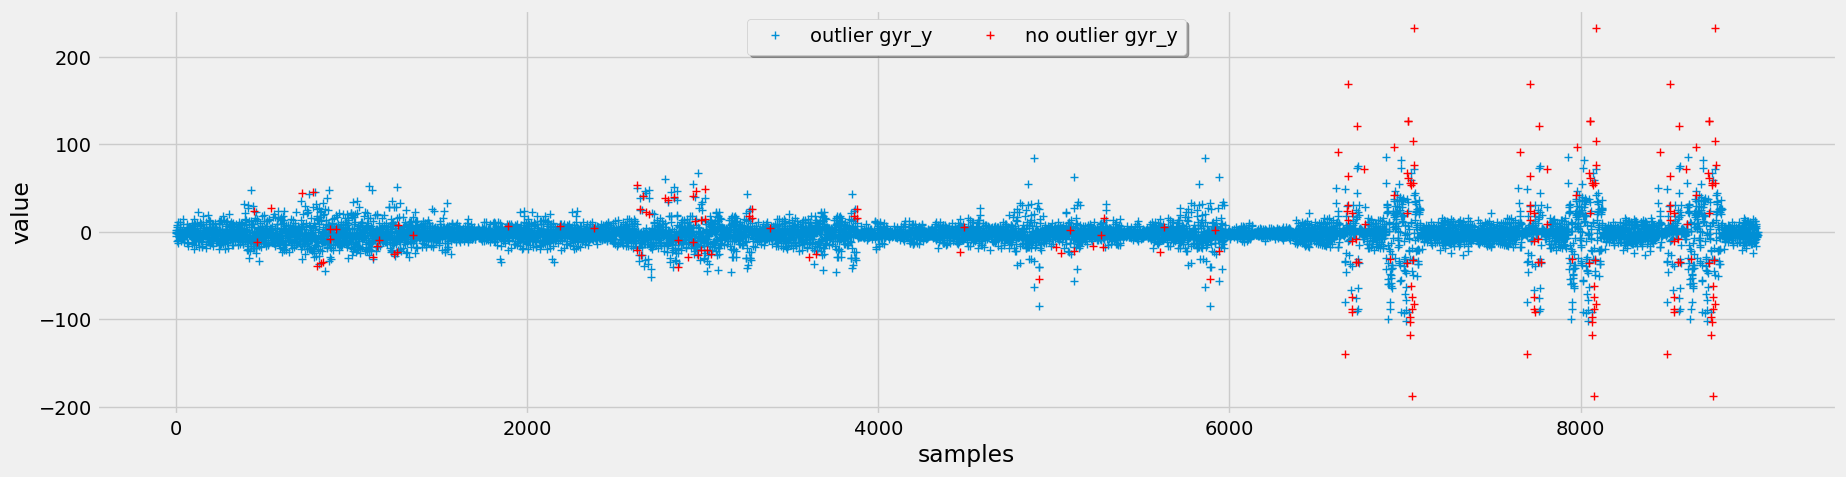

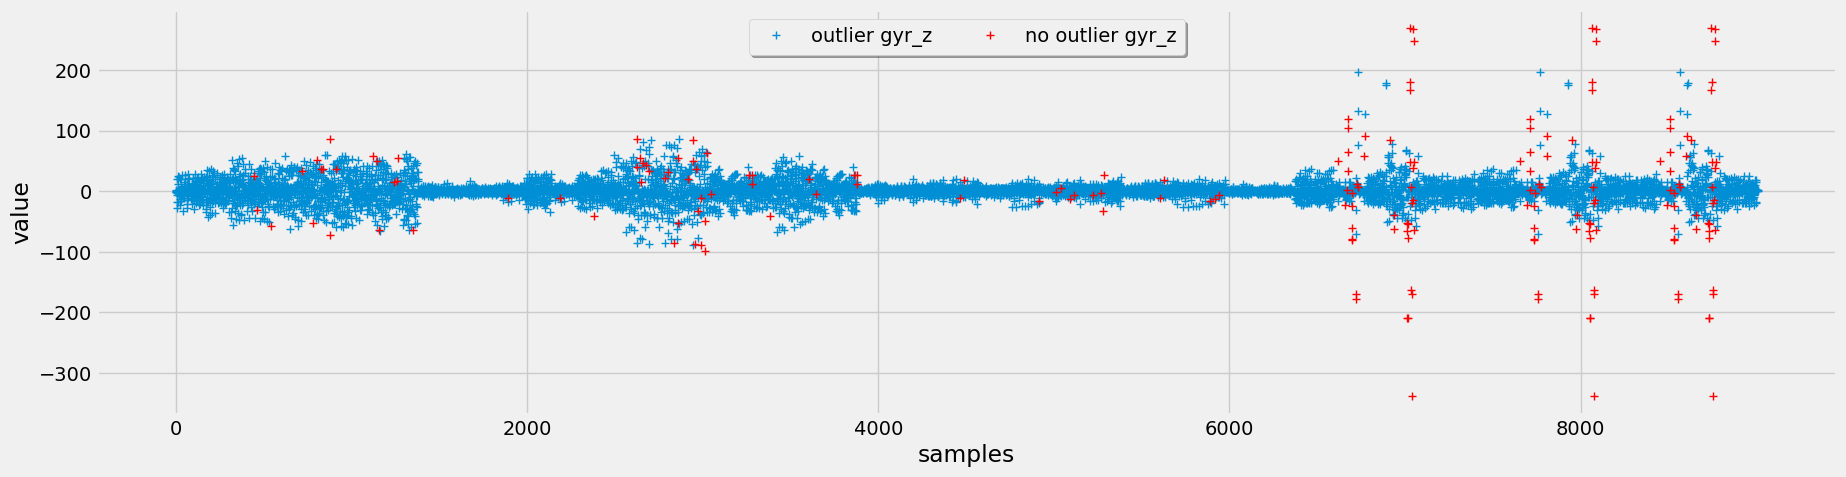

In [23]:
# Test the LOF method on all columns
dataset, outliers, X_scores = mark_outliers_lof(df, outlier_columns)
for col in outlier_columns:
    plot_binary_outliers(
        dataset=dataset, col=col, outlier_col="outlier_lof", reset_index=True
    )

The LOF method found outliers that seem within normal ranges but are identified as isolated data points due to distance from other clusters. 

#### 4.6 - Check for Outliers Grouped by Excercise Type